In [1]:
def height_lut(sat='GPM'):

    x2=2.*17.0;
    re=6378.;
    theta=(-1.*x2/2+(x2/48.)*np.arange(50))*np.pi/180.;
    prheightref=np.zeros([176,49],'double')

    for i in np.arange(176):

        for j in np.arange(49):

            a=np.arcsin(((re+407.)/re)*np.sin(theta[j]))-theta[j];

            prheightref[i,j]=(176-i)*0.125*np.cos(theta[j]+a);

    return prheightref


def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data

# main
import os 
import matplotlib as mpl
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
#import matplotlib.ticker as mticker
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import glob
from pyhdf.SD import SD, SDC
import h5py


#fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/2018/colocated_file_1505_parallax_2018059.0130.txt')
#fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/colocated_file_1505_parallax_2018310.1710.txt')
stratiform_rain=np.zeros((11,11,2),'i') #get the pdf of rain type fraction in 41x41 km2 area
convection_rain=np.zeros((11,11,2),'i')
other_rain = np.zeros((11,11,2),'i')
all_rain =np.zeros((11,11,2),'i')
CFAD=np.zeros((100,176,2,11,4),'i') # dbz,altitude, latitude-0-trop,1-mid,probability, raintype (0-invalid,1-strati,2-convec,3-other)
CFAD=np.zeros((100,176,2,11,4),'i')

years=['2014','2015','2016','2017','2018','2019','2020']
#years=['2014']
for year in years:
    print(year)
    fnames=glob.glob('/data/keeling/a/yulanh/mydata/OT_modis/GPM-Terra/'+year+'/colocated_file_1505_parallax*')
    gpm_altitude=height_lut()
    #print(fnames)

    #fnames=fnames[0:2]
    for fname in fnames:

        file_size=os.path.getsize(fname)

        if (file_size ==0):
            os.system('rm '+fname)

        if (file_size > 0) :
            #print(fname,file_size)
            year_st=fname[83:87]
            day_st =fname[87:90]
            #print(year_st,day_st)
            start_date=date(int(year_st),1,1)
            convt_date=start_date+timedelta(days=int(day_st)-1)
            date_res  = convt_date.strftime("%m-%d-%y")
            month_st=date_res[0:2]

            data=read_text(fname)
            splitcol=data[0].split(' ')
            Ncol=len(splitcol)-splitcol.count('')
            Nrow=len(data)
            #print(Ncol,Nrow)
            # transfer data from string to float
            dataT=np.zeros((Nrow,Ncol),'f')

            for i in range(Nrow):
                splitcol=data[i].split(' ')
                #print(splitcol)

                k=0
                for j in range(len(splitcol)):
                    if splitcol[j] != '' and splitcol[j] != '\n' :
                        if (k==8):
                            gpm_swnum=splitcol[j]
                        dataT[i,k]=float(splitcol[j])
                        k=k+1
                        #print(gpm_swnum)

                # read_hdf5 and get gpm data
                gpm_fname=glob.glob('/data/accp/a/snesbitt/gpmdata/radar/'+year_st+'/'+month_st+'/'+'*'+gpm_swnum+'*')
                #print(gpm_swnum,gpm_fname,fname)
                surf_alt = dataT[i,9]/1000.
                tp_OTlat = dataT[i,13]
                #tp_OTlon = dataT[i,12]
                #tropopause_hgt=dataT[i,4]
                OT_proba = dataT[i,14]
                #print(OT_proba,tp_OTlon,tp_OTlat)
                #print(tropopause_hgt)
                #lat_scp = round((tp_OTlat+90-2.5)/5.0)
                #lon_scp = round((tp_OTlon+180-2.5)/5.0)
                proba_scp=round(OT_proba/0.1)
                #print(proba_scp,OT_proba)
                #colocate_num[lon_scp,lat_scp]=colocate_num[lon_scp,lat_scp]+1
                #print(lat_scp)
                #print(surf_alt,dataT)
                fid=h5py.File(gpm_fname[0],'r')
                #==read radar reflectivity =====
               
                gpm_dbz = fid['NS/SLV/zFactorCorrected'][:]
                gpm_raintype = fid['NS/CSF/typePrecip'][:]

                gpm_dbz_size=gpm_raintype.shape
                nray_scp=int(dataT[i,0])-1
                nscan_scp=int(dataT[i,1])-1
                nscan_x1=nscan_scp-8
                nscan_x2=nscan_scp+8
                nray_x1 =nray_scp-8
                nray_x2 =nray_scp+8 # parallax may cause 20 km biases, OT diameter ~ 20 km, storm moving distance max ~18 km(assuming wind speed 30 m/s)
                #print(gpm_raintype.shape,gpm_dbz.shape,gpm_dbz_size)

                if (nscan_x1 <0):
                    nscan_x1=0
                if (nscan_x2 > gpm_dbz_size[0]-1):
                    nscan_x2=gpm_dbz_size[0]-1
                if (nray_x1 < 0):
                    nray_x1=0
                if (nray_x2 > gpm_dbz_size[1]-1):
                    nray_x2=gpm_dbz_size[1]-1


                # get the CFAD in 41x41 km2 centered to the OT candidate, being consistent with the the OT method
                tp_gpm_dbz =gpm_dbz[nscan_x1:nscan_x2,nray_x1:nray_x2,:]
                tp_altitude=gpm_altitude[:,nray_x1:nray_x2]
                #print(tp_gpm_dbz.shape,tp_altitude.shape)

                tp_gpm_rain=gpm_raintype[nscan_x1:nscan_x2,nray_x1:nray_x2]
                dim_size=tp_gpm_dbz.shape
                #print(tp_gpm_rain.shape,tp_gpm_dbz.shape,nscan_scp,nray_scp)
             

                tp_gpm_rain_int=np.floor(tp_gpm_rain/10000000)
                index1=np.where(tp_gpm_rain_int ==2)[0]
                index2=np.where(tp_gpm_rain_int ==1)[0]
                index3=np.where(tp_gpm_rain_int ==3)[0]
                index4=np.where(tp_gpm_rain_int < 0)[0]
                total_pixel=dim_size[0]*dim_size[1]
                frac_stratiform=10*len(index2)/total_pixel
                frac_convection=10*len(index1)/total_pixel
                frac_other = 10*(len(index3)/total_pixel)
                frac_all  = 10*(len(index1)+len(index2)+len(index3))/total_pixel
                scp_stratiform = round(frac_stratiform)
                scp_convection = round(frac_convection)
                scp_other = round(frac_other)
                scp_all = round(frac_all)
                #print(tp_gpm_rain)
                
                #print(frac_convection,frac_all,tp_OTlat)
                if abs(tp_OTlat) <= 25:
                    stratiform_rain[scp_stratiform, proba_scp,0]=stratiform_rain[scp_stratiform, proba_scp,0]+1
                    convection_rain[scp_convection, proba_scp,0]=convection_rain[scp_convection, proba_scp,0]+1
                    other_rain[scp_other, proba_scp,0]=other_rain[scp_other, proba_scp,0]+1
                    all_rain[scp_all, proba_scp,0]=all_rain[scp_all, proba_scp,0]+1

                if abs(tp_OTlat) > 25:
                    stratiform_rain[scp_stratiform, proba_scp,1]=stratiform_rain[scp_stratiform, proba_scp,1]+1
                    convection_rain[scp_convection, proba_scp,1]=convection_rain[scp_convection, proba_scp,1]+1
                    other_rain[scp_other, proba_scp,1]=other_rain[scp_other, proba_scp,1]+1
                    all_rain[scp_all, proba_scp,1]=all_rain[scp_all, proba_scp,1]+1
                    
                
                ave_dbz = np.zeros(dim_size[2],'i')
                ave_dbz20 = np.zeros(dim_size[2],'i')
                ave_gpm_alt=np.mean(tp_altitude,axis=1) 
                
                for gi in range(dim_size[0]):
                    for gj in range(dim_size[1]):
                        tp_gpm_dbz_1=tp_gpm_dbz[gi,gj,:]
                        tp_altitude_1=tp_altitude[:,gj]
                        tp_raintype = int(tp_gpm_rain_int[gi,gj])
                        if (tp_raintype < 0):
                            tp_raintype=0
                        #print(tp_gpm_dbz_1.shape,tp_altitude_1.shape)
                        index=np.where(tp_gpm_dbz_1 >= 15) # only consider dbz > 15
                        x=index[0]
                    
                        for gz in x:
                            if(tp_altitude_1[gz] > surf_alt):
                            #print(gz,tp_altitude_1[gz],tp_gpm_dbz_1[gz])
                                dbz_scp = round(tp_gpm_dbz_1[gz])
                                ave_dbz[gz] = ave_dbz[gz] +1
                       
                                if abs(tp_OTlat) <= 25:
                                    CFAD[dbz_scp,gz,0,proba_scp,tp_raintype]=CFAD[dbz_scp,gz,0,proba_scp,tp_raintype]+1
                            
                                if abs(tp_OTlat) > 25:
                                    CFAD[dbz_scp,gz,1,proba_scp,tp_raintype]=CFAD[dbz_scp,gz,1,proba_scp,tp_raintype]+1
                                      
                            
print('finish')

2014
2015
2016
2017
2018
2019
2020
finish


/tmp/ipykernel_227333/164003390.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  a1=ax.plot(x, convection_num_3[:,1]/np.sum( convection_num_3[:,1]),'o-',color='black',linestyle='-')
/tmp/ipykernel_227333/164003390.py:50: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  a1=ax.plot(x, stratiform_num_3[:,1]/np.sum( stratiform_num_3[:,1]),'o-',color='black',linestyle='-')
/tmp/ipykernel_227333/164003390.py:80: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  a1=ax.plot(x, all_num_3[:,1]/np.sum( all_num_3[:,1]),'o-',color='black',linestyle='-')


[ 52 156 229 203 170 155 154  80  50  20   5] 0.04081632653061224
[134 175 204 161 134  98  46  28  28  15   7] 0.13009708737864079
[ 23  17  55  85 118 135 172 166 160 163 180] 0.01805337519623234
[102  48  78  95 106 129 115 106  75  75 101] 0.09902912621359224


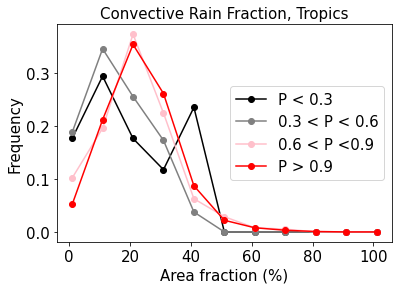

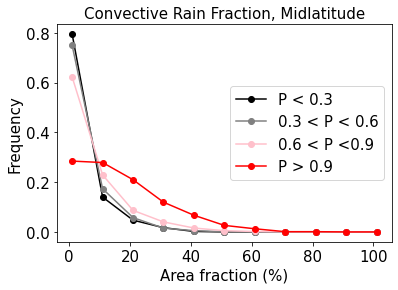

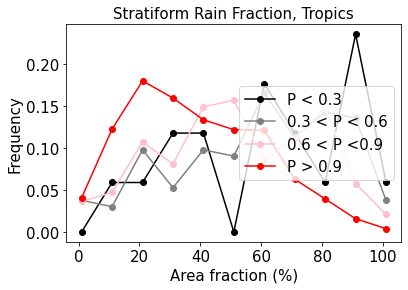

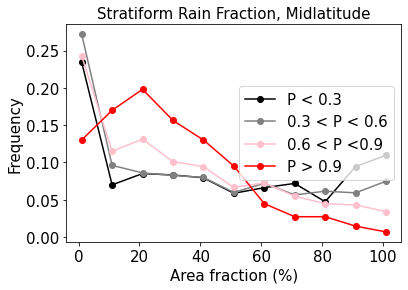

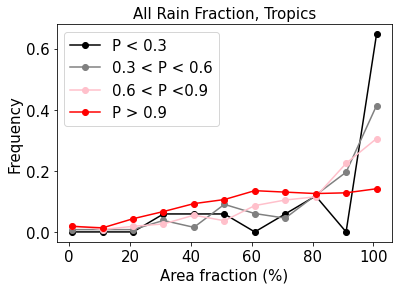

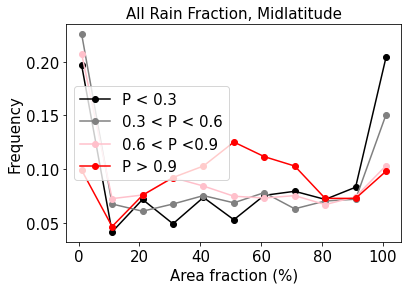

In [23]:
x=np.arange(11)*10+1
fontsz=15
#convective rain
convection_num_3=np.sum(convection_rain[:,0:3,:],1)
convection_num_6=np.sum(convection_rain[:,3:6,:],1)
convection_num_9=np.sum(convection_rain[:,6:9,:],1)
convection_num_10=np.sum(convection_rain[:,9:11,:],1)

fig,ax =plt.subplots(1)
a1=ax.plot(x, convection_num_3[:,0]/np.sum(convection_num_3[:,0]),'o-',color='black')
a2=ax.plot(x, convection_num_6[:,0]/np.sum(convection_num_6[:,0]),'o-',color='grey')
a3=ax.plot(x, convection_num_9[:,0]/np.sum(convection_num_9[:,0]),'o-',color='pink')
a4=ax.plot(x, convection_num_10[:,0]/np.sum(convection_num_10[:,0]),'o-',color='r')
ax.set_title('Convective Rain Fraction, Tropics',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=5,fontsize=15)

fig,ax =plt.subplots(1)
a1=ax.plot(x, convection_num_3[:,1]/np.sum( convection_num_3[:,1]),'o-',color='black',linestyle='-')
a2=ax.plot(x, convection_num_6[:,1]/np.sum( convection_num_6[:,1]),'o-',color='grey')
a3=ax.plot(x, convection_num_9[:,1]/np.sum( convection_num_9[:,1]),'o-',color='pink')
a4=ax.plot(x, convection_num_10[:,1]/np.sum( convection_num_10[:,1]),'o-',color='r')
ax.set_title('Convective Rain Fraction, Midlatitude',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=5,fontsize=15)

#stratiform rain
stratiform_num_3=np.sum(stratiform_rain[:,0:3,:],1)
stratiform_num_6=np.sum(stratiform_rain[:,3:6,:],1)
stratiform_num_9=np.sum(stratiform_rain[:,6:9,:],1)
stratiform_num_10=np.sum(stratiform_rain[:,9:11,:],1)

fig,ax =plt.subplots(1)
a1=ax.plot(x,stratiform_num_3[:,0]/np.sum(stratiform_num_3[:,0]),'o-',color='black')
a2=ax.plot(x, stratiform_num_6[:,0]/np.sum(stratiform_num_6[:,0]),'o-',color='grey')
a3=ax.plot(x, stratiform_num_9[:,0]/np.sum(stratiform_num_9[:,0]),'o-',color='pink')
a4=ax.plot(x, stratiform_num_10[:,0]/np.sum(stratiform_num_10[:,0]),'o-',color='r')
ax.set_title('Stratiform Rain Fraction, Tropics',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=5,fontsize=15)


fig,ax =plt.subplots(1)
a1=ax.plot(x, stratiform_num_3[:,1]/np.sum( stratiform_num_3[:,1]),'o-',color='black',linestyle='-')
a2=ax.plot(x, stratiform_num_6[:,1]/np.sum( stratiform_num_6[:,1]),'o-',color='grey')
a3=ax.plot(x, stratiform_num_9[:,1]/np.sum( stratiform_num_9[:,1]),'o-',color='pink')
a4=ax.plot(x, stratiform_num_10[:,1]/np.sum( stratiform_num_10[:,1]),'o-',color='r')
ax.set_title('Stratiform Rain Fraction, Midlatitude',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=5,fontsize=15)
print(stratiform_num_10[:,0],stratiform_num_10[0,0]/np.sum(stratiform_num_10[:,0]))
print(stratiform_num_10[:,1],stratiform_num_10[0,1]/np.sum(stratiform_num_10[:,1]))

#all rain
all_num_3=np.sum(all_rain[:,0:3,:],1)
all_num_6=np.sum(all_rain[:,3:6,:],1)
all_num_9=np.sum(all_rain[:,6:9,:],1)
all_num_10=np.sum(all_rain[:,9:11,:],1)
fig,ax =plt.subplots(1)
a1=ax.plot(x,all_num_3[:,0]/np.sum(all_num_3[:,0]),'o-',color='black')
a2=ax.plot(x, all_num_6[:,0]/np.sum(all_num_6[:,0]),'o-',color='grey')
a3=ax.plot(x, all_num_9[:,0]/np.sum(all_num_9[:,0]),'o-',color='pink')
a4=ax.plot(x, all_num_10[:,0]/np.sum(all_num_10[:,0]),'o-',color='r')
ax.set_title('All Rain Fraction, Tropics',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=2,fontsize=15)


fig,ax =plt.subplots(1)
a1=ax.plot(x, all_num_3[:,1]/np.sum( all_num_3[:,1]),'o-',color='black',linestyle='-')
a2=ax.plot(x, all_num_6[:,1]/np.sum( all_num_6[:,1]),'o-',color='grey')
a3=ax.plot(x, all_num_9[:,1]/np.sum( all_num_9[:,1]),'o-',color='pink')
a4=ax.plot(x, all_num_10[:,1]/np.sum( all_num_10[:,1]),'o-',color='r')
ax.set_title('All Rain Fraction, Midlatitude',fontsize=fontsz)
ax.set_xlabel('Area fraction (%)',fontsize=fontsz)
ax.tick_params(labelsize=15)
ax.set_ylabel('Frequency',fontsize=fontsz)
ax.legend(['P < 0.3','0.3 < P < 0.6','0.6 < P <0.9','P > 0.9'],loc=6,fontsize=15)
print(all_num_10[:,0],all_num_10[0,0]/np.sum(all_num_10[:,0]))
print(all_num_10[:,1],all_num_10[0,1]/np.sum(all_num_10[:,1]))



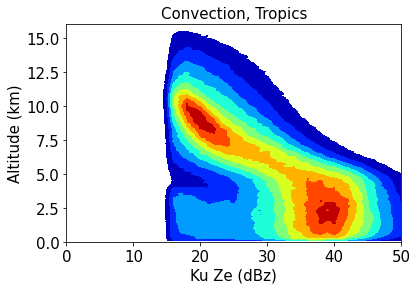

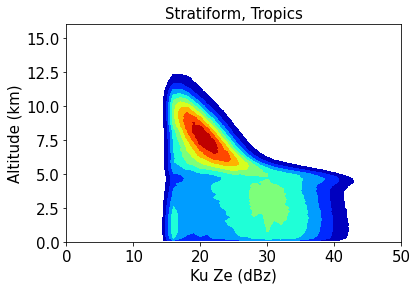

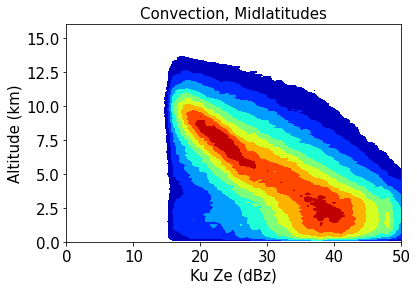

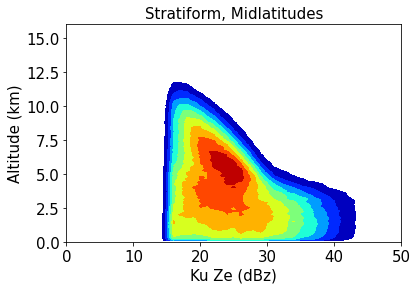

In [13]:
#print(np.sum(colocate_num))
fontsz=15

xdbz=np.arange(100)
gpm_center_altitude=(176-np.arange(176))*0.125

CFAD_9=np.sum(CFAD[:,:,:,9:11,:],axis=3)

convection_cfad_trop=np.zeros((100,176),'f')
convection_cfad_mid =np.zeros((100,176),'f')
stratiform_cfad_trop=np.zeros((100,176),'f')
stratiform_cfad_mid =np.zeros((100,176),'f')

for j in np.arange(176):
    convection_cfad_trop[:,j]=CFAD_9[:,j,0,2]/float(np.max(CFAD_9[:,:,0,2]))
    convection_cfad_mid[:,j]=CFAD_9[:,j,1,2]/float(np.max(CFAD_9[:,:,1,2]))
    stratiform_cfad_trop[:,j]=CFAD_9[:,j,0,1]/float(np.max(CFAD_9[:,:,0,1]))
    stratiform_cfad_mid[:,j]=CFAD_9[:,j,1,1]/float(np.max(CFAD_9[:,:,1,1]))

fig,ax =plt.subplots(1)
p=ax.contourf(xdbz,gpm_center_altitude,np.transpose(convection_cfad_trop),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],\
 cmap='jet')
ax.set_title('Convection, Tropics',fontsize=fontsz)
ax.set_ylabel('Altitude (km)',fontsize=fontsz)
ax.set_xlabel('Ku Ze (dBz)',fontsize=fontsz)
ax.set_xlim([0,50])
ax.set_ylim([0,16])
ax.set_xticks([0,10,20,30,40,50])
ax.set_xticks([0,10,20,30,40,50])
ax.tick_params(labelsize=fontsz)

fig,ax =plt.subplots(1)
p=ax.contourf(xdbz,gpm_center_altitude,np.transpose(stratiform_cfad_trop),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],\
 cmap='jet')
ax.set_title('Stratiform, Tropics',fontsize=fontsz)
ax.set_ylabel('Altitude (km)',fontsize=fontsz)
ax.set_xlabel('Ku Ze (dBz)',fontsize=fontsz)
ax.set_xlim([0,50])
ax.set_ylim([0,16])
ax.set_xticks([0,10,20,30,40,50])
ax.set_xticks([0,10,20,30,40,50])
ax.tick_params(labelsize=fontsz)

fig,ax =plt.subplots(1)
p=ax.contourf(xdbz,gpm_center_altitude,np.transpose(convection_cfad_mid),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],\
 cmap='jet')
ax.set_title('Convection, Midlatitudes',fontsize=fontsz)
ax.set_ylabel('Altitude (km)',fontsize=fontsz)
ax.set_xlabel('Ku Ze (dBz)',fontsize=fontsz)
ax.set_xlim([0,50])
ax.set_ylim([0,16])
ax.set_xticks([0,10,20,30,40,50])
ax.set_xticks([0,10,20,30,40,50])
ax.tick_params(labelsize=fontsz)

fig,ax =plt.subplots(1)
p=ax.contourf(xdbz,gpm_center_altitude,np.transpose(stratiform_cfad_mid),[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],\
 cmap='jet')
ax.set_title('Stratiform, Midlatitudes',fontsize=fontsz)
ax.set_ylabel('Altitude (km)',fontsize=fontsz)
ax.set_xlabel('Ku Ze (dBz)',fontsize=fontsz)
ax.set_xlim([0,50])
ax.set_ylim([0,16])
ax.set_xticks([0,10,20,30,40,50])
ax.set_xticks([0,10,20,30,40,50])
ax.tick_params(labelsize=fontsz)